In [1]:
!nvidia-smi

Sat Mar 11 15:05:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    48W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports

In [2]:
!pip install -q tensorflow==2.11.0
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.2 MB/s eta 0:00:00


In [3]:
# Log in to your W&B account
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
import numpy as np
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras import mixed_precision
from typing import Tuple
from matplotlib import pyplot as plt

# Set seed for reproducibility.
tf.keras.utils.set_random_seed(42)

AUTO = tf.data.AUTOTUNE

In [5]:
print(tf.__version__)

2.11.0


# Configurations

In [6]:
config = {
    "mixed_precision": True,
    "dataset": "imagenette",
    "batch_size": 512,
    "buffer_size": 512 * 2,
    "input_shape": [196, 196, 3],
    "image_size": 224,
    "num_classes": 10,
    "learning_rate": 1e-4,
    "weight_decay": 1e-4,
    "epochs": 50,
    "patch_size": 16,
    "embed_dim": 128,
    "chunk_size": 14,
    "r": 2,
    "num_layers": 6,
    "ffn_drop": 0.2,
    "attn_drop": 0.2,
    "num_heads": 1,
}

# Datasets

In [7]:
train_ds, val_ds, test_ds = tfds.load(
    "imagenette", split=["train", "validation[0:80%]", "validation[80%:]"]
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0.incompleteHBRPOI/imagenette-train.tfrecord*.…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0.incompleteHBRPOI/imagenette-validation.tfrec…

Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0. Subsequent calls will reuse this data.


In [8]:
# Build the `train` augmentation pipeline.
train_aug = keras.Sequential(
    [
        layers.Rescaling(1 / 255.0),
        layers.Resizing(config["input_shape"][0] + 20, config["input_shape"][0] + 20),
        layers.RandomCrop(config["image_size"], config["image_size"]),
        layers.RandomFlip("horizontal"),
    ],
    name="train_data_augmentation",
)

# Build the `val` and `test` data pipeline.
test_aug = keras.Sequential(
    [
        layers.Rescaling(1 / 255.0),
        layers.Resizing(config["image_size"], config["image_size"]),
    ],
    name="test_data_augmentation",
)

In [9]:
def train_map_fn(element):
    return train_aug(element["image"]), element["label"]


def test_map_fn(element):
    return test_aug(element["image"]), element["label"]

In [10]:
train_ds = (
    train_ds.map(train_map_fn, num_parallel_calls=AUTO)
    .shuffle(config["buffer_size"])
    .batch(config["batch_size"], num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

val_ds = (
    val_ds.map(test_map_fn, num_parallel_calls=AUTO)
    .batch(config["batch_size"], num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

test_ds = (
    test_ds.map(test_map_fn, num_parallel_calls=AUTO)
    .batch(config["batch_size"], num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

In [11]:
total_batches_train = tf.data.experimental.cardinality(train_ds).numpy()
total_batches_train

19

# PatchEmbedding

In [12]:
class PatchEmbed(layers.Layer):
    """Image patch embedding layer.

    Args:
        image_size (Tuple[int]): Input image resolution.
        patch_size (Tuple[int]): Patch spatial resolution.
        embed_dim (int): Embedding dimension.
        add_pos_info (bool): Whether to add positional information to tokens.
    """

    def __init__(
        self,
        image_size: Tuple[int] = (48, 48),
        patch_size: Tuple[int] = (4, 4),
        embed_dim: int = 32,
        chunk_size: int = 8,
        **kwargs,
    ):
        super().__init__(**kwargs)
        patch_resolution = [
            image_size[0] // patch_size[0],
            image_size[1] // patch_size[1],
        ]
        self.image_size = image_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.patch_resolution = patch_resolution
        self.num_patches = patch_resolution[0] * patch_resolution[1]
        self.proj = layers.Conv2D(
            filters=embed_dim, kernel_size=patch_size, strides=patch_size
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=embed_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)
        self.norm = keras.layers.LayerNormalization(epsilon=1e-5)
        self.chunking_layer = layers.Reshape(
            target_shape=(self.num_patches // chunk_size, chunk_size, embed_dim)
        )

    def call(self, x: tf.Tensor) -> Tuple[tf.Tensor, int, int, int]:
        """Patchifies the image, converts into tokens and adds pos information.

        Args:
            x: Tensor of shape (B, H, W, C)

        Returns:
            A tuple of the processed tensor, height of the projected
            feature map, width of the projected feature map, number
            of channels of the projected feature map.
        """
        # Project the inputs.
        x = self.proj(x)
        x = self.flatten(x)
        x = x + self.position_embedding(self.positions)

        # B, H, W, C -> B, H*W, C
        x = self.norm(x)

        # Chunk the tokens in K
        x = self.chunking_layer(x)

        return x

# FFN

In [13]:
class FeedForwardNetwork(layers.Layer):
    """Feed Forward Network.

    Args:
        dims (`int`): Dimension of the FFN.
        dropout (`float`): Dropout probability of FFN.
    """

    def __init__(self, dims: int, dropout: float = 0.1, **kwargs):
        super().__init__(**kwargs)
        self.ffn = keras.Sequential(
            [
                layers.Dense(units=4 * dims, activation=tf.nn.gelu),
                layers.Dense(units=dims),
                layers.Dropout(rate=dropout),
            ]
        )
        self.add = layers.Add()
        self.layernorm = layers.LayerNormalization(epsilon=1e-5)

    def call(self, inputs: tf.Tensor):
        x = self.layernorm(inputs)
        x = self.add([inputs, self.ffn(x)])
        return x

# Attention

In [14]:
class BaseAttention(layers.Layer):
    """The base attention module.

    Args:
        num_heads (`int`): Number of attention heads.
        key_dim (`int`): Size of each attention head for query and key.
        dropout (`float`): Dropout probability for Attention Module.

    """

    def __init__(self, num_heads: int, key_dim: int, dropout: float = 0.1, **kwargs):
        super().__init__(**kwargs)
        self.mha = layers.MultiHeadAttention(num_heads, key_dim, dropout=dropout)
        self.q_layernorm = layers.LayerNormalization(epsilon=1e-5)
        self.k_layernorm = layers.LayerNormalization(epsilon=1e-5)
        self.v_layernorm = layers.LayerNormalization(epsilon=1e-5)
        self.add = layers.Add()

    def call(self, input_query: tf.Tensor, key: tf.Tensor, value: tf.Tensor):
        query = self.q_layernorm(input_query)
        key = self.k_layernorm(key)
        value = self.v_layernorm(value)
        (attn_outs, attn_scores) = self.mha(
            query=query,
            key=key,
            value=value,
            return_attention_scores=True,
        )
        self.attn_scores = attn_scores
        x = self.add([input_query, attn_outs])
        return x

In [15]:
class AttentionWithFFN(layers.Layer):
    """Self-attention module with FFN

    Args:
        ffn_dims (`int`): Number of units in FFN.
        ffn_dropout (`float`): Dropout probability for FFN.
        num_heads (`int`): Number of attention heads.
        key_dim (`int`): Size of each attention head for query and key.
        attn_dropout (`float`): Dropout probability for attention module.
    """

    def __init__(
        self,
        ffn_dims: int = 128,
        ffn_dropout: float = 0.1,
        num_heads: int = 4,
        key_dim: int = 256,
        attn_dropout: float = 0.1,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.attention = BaseAttention(
            num_heads, key_dim, attn_dropout, name="BaseAttention"
        )
        self.ffn = FeedForwardNetwork(ffn_dims, ffn_dropout, name="FeedForward")

    def call(self, query: tf.Tensor, key: tf.Tensor, value: tf.Tensor):
        x = self.attention(query, key, value)
        self.attn_scores = self.attention.attn_scores
        x = self.ffn(x)
        return x

# Recurrence

In [16]:
class CustomCell(layers.Layer):
    """Custom logic inside each recurrence.

    Args:
        chunk_size (`int`): Chunk size of the inputs.
        r (`int`): One Cross Attention per **r** Self Attention.
        num_layers (`int`): Number of layers in the Perceptual Model.
        ffn_dims (`int`): Number of units in FFN.
        ffn_dropout (`float`): Dropout probability for FFN.
        num_heads (`int`): Number of attention heads.
        key_dim (`int`): Size of each attention head for query and key.
        attn_dropout (`float`): Dropout probability for attention module.
    """

    def __init__(
        self,
        chunk_size,
        r=2,
        num_layers: int = 5,
        ffn_dims: int = 128,
        ffn_dropout: float = 0.1,
        num_heads: int = 4,
        key_dim: int = 256,
        attn_dropout: float = 0.1,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.chunk_size = chunk_size
        self.r = r
        self.num_layers = num_layers
        self.ffn_dims = ffn_dims
        self.ffn_droput = ffn_dropout
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.attn_dropout = attn_dropout

        self.state_size = tf.TensorShape([chunk_size, ffn_dims])
        self.output_size = tf.TensorShape([chunk_size, ffn_dims])

        self.get_attn_scores = False
        self.attn_scores = []

        ########################################################################
        # Perceptual Module
        ########################################################################
        perceptual_module = list()
        for layer_idx in range(num_layers):
            perceptual_module.append(
                AttentionWithFFN(
                    ffn_dims=ffn_dims,
                    ffn_dropout=ffn_dropout,
                    num_heads=num_heads,
                    key_dim=key_dim,
                    attn_dropout=attn_dropout,
                    name=f"PM_SelfAttentionFFN{layer_idx}",
                )
            )
            if layer_idx % r == 0:
                perceptual_module.append(
                    AttentionWithFFN(
                        ffn_dims=ffn_dims,
                        ffn_dropout=ffn_dropout,
                        num_heads=num_heads,
                        key_dim=key_dim,
                        attn_dropout=attn_dropout,
                        name=f"PM_CrossAttentionFFN{layer_idx}",
                    )
                )
        self.perceptual_module = perceptual_module

        ########################################################################
        # Temporal Latent Bottleneck Module
        ########################################################################
        self.tlb_module = AttentionWithFFN(
            ffn_dims=ffn_dims,
            ffn_dropout=ffn_dropout,
            num_heads=num_heads,
            key_dim=key_dim,
            attn_dropout=attn_dropout,
            name=f"TLBM_CrossAttentionFFN",
        )

    def call(self, inputs, states, training=None):
        # inputs => (batch, chunk_size, dims)
        # states => [(batch, chunk_size, units)]

        slow_stream = states[0]
        fast_stream = inputs

        for layer_idx, layer in enumerate(self.perceptual_module):
            fast_stream = layer(query=fast_stream, key=fast_stream, value=fast_stream)

            if layer_idx % self.r == 0:
                fast_stream = layer(
                    query=fast_stream, key=slow_stream, value=slow_stream
                )

        slow_stream = self.tlb_module(
            query=slow_stream, key=fast_stream, value=fast_stream
        )

        if self.get_attn_scores:
            self.attn_scores.append(self.tlb_module.attn_scores)

        return fast_stream, [slow_stream]

# Build the model

In [17]:
class ModelTrainer(keras.Model):
    def __init__(self, patch_layer, custom_cell, **kwargs):
        super().__init__(**kwargs)
        self.patch_layer = patch_layer
        self.rnn = layers.RNN(custom_cell)
        self.gap = layers.GlobalAveragePooling1D()
        self.head = layers.Dense(10, activation="softmax")

    def call(self, inputs):
        x = self.patch_layer(inputs)
        x = self.rnn(x)
        x = self.gap(x)
        outputs = self.head(x)
        return outputs

In [18]:
keras.backend.clear_session()

# PATCH
patch_layer = PatchEmbed(
    image_size=(config["image_size"], config["image_size"]),
    patch_size=(config["patch_size"], config["patch_size"]),
    embed_dim=config["embed_dim"],
    chunk_size=config["chunk_size"],
)

# RECURRENCE
cell = CustomCell(
    chunk_size=config["chunk_size"],
    r=config["r"],
    num_layers=config["num_layers"],
    ffn_dims=config["embed_dim"],
    ffn_dropout=config["ffn_drop"],
    num_heads=config["num_heads"],
    key_dim=config["embed_dim"],
    attn_dropout=config["attn_drop"],
)


model = ModelTrainer(patch_layer, cell)

In [19]:
run = wandb.init(
    project="temporal-latent-bottleneck",
    entity="ariG23498",
    config=config,
    name="imagenette-50",
)

optimizer = AdamW(
    learning_rate=config["learning_rate"], weight_decay=config["weight_decay"]
)

wandb_callbacks = [
    WandbMetricsLogger(),
    WandbModelCheckpoint(
        filepath="model_{epoch:02d}",
        save_freq=int(10 * total_batches_train),
    ),
]

# Compile and train the model.
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds,
    epochs=config["epochs"],
    validation_data=val_ds,
    callbacks=wandb_callbacks,
)

run.finish()

wandb: Currently logged in as: arig23498. Use `wandb login --relogin` to force relogin


Epoch 1/50
19/19 [==============================] - 159s 2s/step - loss: 3.8834 - accuracy: 0.1264 - val_loss: 2.4164 - val_accuracy: 0.1287
Epoch 2/50
19/19 [==============================] - 35s 2s/step - loss: 2.3727 - accuracy: 0.1563 - val_loss: 2.2211 - val_accuracy: 0.1806
Epoch 3/50
19/19 [==============================] - 35s 2s/step - loss: 2.2350 - accuracy: 0.1895 - val_loss: 2.1969 - val_accuracy: 0.1901
Epoch 4/50
19/19 [==============================] - 35s 2s/step - loss: 2.1890 - accuracy: 0.2106 - val_loss: 2.1381 - val_accuracy: 0.2357
Epoch 5/50
19/19 [==============================] - 36s 2s/step - loss: 2.1199 - accuracy: 0.2428 - val_loss: 2.0616 - val_accuracy: 0.2742
Epoch 6/50
19/19 [==============================] - 35s 2s/step - loss: 2.0769 - accuracy: 0.2565 - val_loss: 2.0867 - val_accuracy: 0.2599
Epoch 7/50
19/19 [==============================] - 35s 2s/step - loss: 2.0595 - accuracy: 0.2634 - val_loss: 2.0286 - val_accuracy: 0.2978
Epoch 8/50
19/19 [=

wandb: Adding directory to artifact (./model_10)... Done. 0.1s


19/19 [==============================] - 95s 5s/step - loss: 1.9901 - accuracy: 0.3018 - val_loss: 2.0100 - val_accuracy: 0.2981
Epoch 11/50
19/19 [==============================] - 35s 2s/step - loss: 1.9628 - accuracy: 0.3038 - val_loss: 1.9448 - val_accuracy: 0.3226
Epoch 12/50
19/19 [==============================] - 35s 2s/step - loss: 1.9062 - accuracy: 0.3310 - val_loss: 1.9880 - val_accuracy: 0.3153
Epoch 13/50
19/19 [==============================] - 35s 2s/step - loss: 1.8979 - accuracy: 0.3347 - val_loss: 1.8794 - val_accuracy: 0.3401
Epoch 14/50
19/19 [==============================] - 35s 2s/step - loss: 1.8774 - accuracy: 0.3394 - val_loss: 1.8570 - val_accuracy: 0.3599
Epoch 15/50
19/19 [==============================] - 35s 2s/step - loss: 1.8283 - accuracy: 0.3634 - val_loss: 1.8397 - val_accuracy: 0.3713
Epoch 16/50
19/19 [==============================] - 35s 2s/step - loss: 1.7949 - accuracy: 0.3695 - val_loss: 1.7870 - val_accuracy: 0.3818
Epoch 17/50
19/19 [======

wandb: Adding directory to artifact (./model_20)... Done. 0.1s


19/19 [==============================] - 94s 5s/step - loss: 1.6235 - accuracy: 0.4434 - val_loss: 1.6362 - val_accuracy: 0.4452
Epoch 21/50
19/19 [==============================] - 35s 2s/step - loss: 1.5887 - accuracy: 0.4533 - val_loss: 1.6122 - val_accuracy: 0.4538
Epoch 22/50
19/19 [==============================] - 35s 2s/step - loss: 1.5432 - accuracy: 0.4694 - val_loss: 1.5767 - val_accuracy: 0.4666
Epoch 23/50
19/19 [==============================] - 35s 2s/step - loss: 1.5233 - accuracy: 0.4742 - val_loss: 1.5728 - val_accuracy: 0.4688
Epoch 24/50
19/19 [==============================] - 35s 2s/step - loss: 1.5242 - accuracy: 0.4814 - val_loss: 1.6329 - val_accuracy: 0.4611
Epoch 25/50
19/19 [==============================] - 35s 2s/step - loss: 1.4797 - accuracy: 0.4993 - val_loss: 1.5563 - val_accuracy: 0.4822
Epoch 26/50
19/19 [==============================] - 35s 2s/step - loss: 1.4303 - accuracy: 0.5199 - val_loss: 1.5215 - val_accuracy: 0.4997
Epoch 27/50
19/19 [======

wandb: Adding directory to artifact (./model_30)... Done. 0.1s


19/19 [==============================] - 95s 5s/step - loss: 1.3544 - accuracy: 0.5423 - val_loss: 1.4889 - val_accuracy: 0.5226
Epoch 31/50
19/19 [==============================] - 35s 2s/step - loss: 1.2981 - accuracy: 0.5653 - val_loss: 1.4601 - val_accuracy: 0.5217
Epoch 32/50
19/19 [==============================] - 35s 2s/step - loss: 1.2809 - accuracy: 0.5691 - val_loss: 1.4680 - val_accuracy: 0.5239
Epoch 33/50
19/19 [==============================] - 35s 2s/step - loss: 1.2800 - accuracy: 0.5731 - val_loss: 1.4842 - val_accuracy: 0.5131
Epoch 34/50
19/19 [==============================] - 35s 2s/step - loss: 1.2486 - accuracy: 0.5817 - val_loss: 1.4453 - val_accuracy: 0.5404
Epoch 35/50
19/19 [==============================] - 35s 2s/step - loss: 1.2168 - accuracy: 0.5919 - val_loss: 1.4914 - val_accuracy: 0.5290
Epoch 36/50
19/19 [==============================] - 35s 2s/step - loss: 1.2159 - accuracy: 0.5948 - val_loss: 1.4314 - val_accuracy: 0.5404
Epoch 37/50
19/19 [======

wandb: Adding directory to artifact (./model_40)... Done. 0.1s


19/19 [==============================] - 94s 5s/step - loss: 1.1242 - accuracy: 0.6240 - val_loss: 1.3831 - val_accuracy: 0.5701
Epoch 41/50
19/19 [==============================] - 35s 2s/step - loss: 1.0987 - accuracy: 0.6288 - val_loss: 1.3627 - val_accuracy: 0.5822
Epoch 42/50
19/19 [==============================] - 36s 2s/step - loss: 1.0535 - accuracy: 0.6485 - val_loss: 1.3697 - val_accuracy: 0.5780
Epoch 43/50
19/19 [==============================] - 35s 2s/step - loss: 1.0346 - accuracy: 0.6531 - val_loss: 1.3499 - val_accuracy: 0.5771
Epoch 44/50
19/19 [==============================] - 35s 2s/step - loss: 1.0377 - accuracy: 0.6529 - val_loss: 1.3229 - val_accuracy: 0.5959
Epoch 45/50
19/19 [==============================] - 35s 2s/step - loss: 0.9837 - accuracy: 0.6757 - val_loss: 1.3350 - val_accuracy: 0.5962
Epoch 46/50
19/19 [==============================] - 35s 2s/step - loss: 0.9755 - accuracy: 0.6726 - val_loss: 1.3419 - val_accuracy: 0.5914
Epoch 47/50
19/19 [======

wandb: Adding directory to artifact (./model_50)... Done. 0.1s


19/19 [==============================] - 95s 5s/step - loss: 0.9006 - accuracy: 0.7011 - val_loss: 1.3265 - val_accuracy: 0.6102


epoch/accuracy,▁▁▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇████████
epoch/val_loss,█▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
epoch/accuracy,0.70113
epoch/epoch,49
epoch/learning_rate,0.0001
epoch/loss,0.90064
epoch/val_accuracy,0.61019


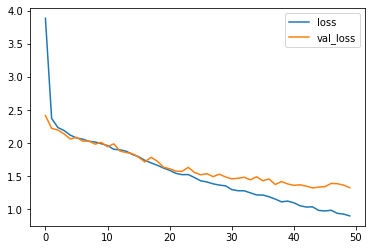

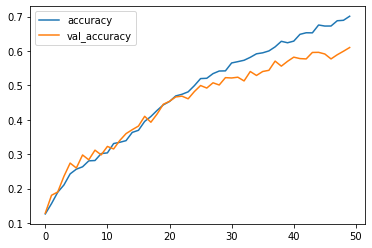

In [20]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

# Visualize the Latent Bottleneck

In [21]:
images, labels = next(iter(test_ds))

# Set the flag for attn score
model.rnn.cell.get_attn_scores = True
outputs = model(images)

In [22]:
# Grab the list of chunk scores
list_chunk_scores = model.rnn.cell.attn_scores

In [23]:
def score_to_viz(chunk_score):
    chunk_viz = tf.math.reduce_max(chunk_score, axis=-2)  # get the most attended token
    chunk_viz = tf.math.reduce_mean(chunk_viz, axis=1)  # get the mean across heads
    return chunk_viz

In [24]:
list_chunk_viz = [score_to_viz(x) for x in list_chunk_scores]

In [25]:
chunk_viz = tf.concat(list_chunk_viz[1:], axis=-1)
chunk_viz = tf.reshape(
    chunk_viz,
    (
        config["batch_size"],
        config["image_size"] // config["patch_size"],
        config["image_size"] // config["patch_size"],
        1,
    ),
)

In [26]:
upsampled_heat_map = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(
    chunk_viz
)

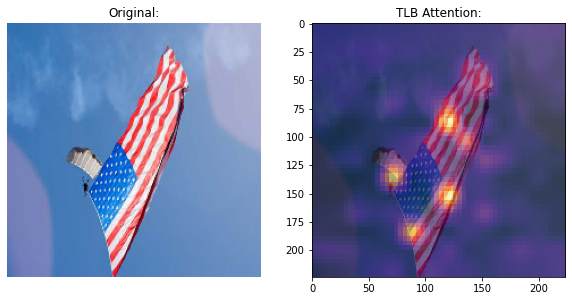

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

index = 5
orig_image = images[index]
overlay_image = upsampled_heat_map[index, ..., 0]

ax[0].imshow(orig_image)
ax[0].set_title("Original:")
ax[0].axis("off")

image = ax[1].imshow(orig_image)
ax[1].imshow(overlay_image, cmap="inferno", alpha=0.6, extent=image.get_extent())
ax[1].set_title("TLB Attention:")

plt.show()